In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import requests
import xmltodict
import json

from datetime import datetime
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거
warnings.filterwarnings(action='ignore')

In [16]:
train = pd.read_parquet('./data/train.parquet')
test = pd.read_parquet('./data/test.parquet')

In [17]:
# train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


start_node_name과 end_node_name으로 고유 도로 만들기

In [13]:
# train[(train['start_node_name'] == '가동') & (train['end_node_name'] != '나동')]

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
431,TRAIN_0000431,20211226,일,9,1,107,-,0,0,50.0,...,0,가동,33.418412,126.268029,없음,수원씽크공장,33.420614,126.273077,없음,27.0
1440,TRAIN_0001440,20220128,금,16,2,107,-,0,0,60.0,...,0,가동,33.418412,126.268029,없음,원일공사,33.417801,126.264684,없음,11.0
1555,TRAIN_0001555,20220212,토,19,1,107,-,0,0,50.0,...,0,가동,33.418412,126.268029,없음,수원씽크공장,33.420614,126.273077,없음,30.0
1886,TRAIN_0001886,20220208,화,0,2,107,-,0,0,60.0,...,0,가동,33.418412,126.268029,없음,원일공사,33.417801,126.264684,없음,40.0
3681,TRAIN_0003681,20210915,수,6,2,107,-,0,0,60.0,...,0,가동,33.418412,126.268029,없음,원일공사,33.417801,126.264684,없음,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4697581,TRAIN_4697581,20220527,금,22,2,107,-,0,0,60.0,...,0,가동,33.418412,126.268029,없음,원일공사,33.417801,126.264684,없음,16.0
4698463,TRAIN_4698463,20220510,화,21,2,107,-,0,0,60.0,...,0,가동,33.418412,126.268029,없음,원일공사,33.417801,126.264684,없음,20.0
4699923,TRAIN_4699923,20220107,금,20,1,107,-,0,0,50.0,...,0,가동,33.418412,126.268029,없음,수원씽크공장,33.420614,126.273077,없음,23.0
4699926,TRAIN_4699926,20220221,월,13,1,107,-,0,0,50.0,...,0,가동,33.418412,126.268029,없음,수원씽크공장,33.420614,126.273077,없음,27.0


In [188]:
# # train['start_end_node_name'] = train['start_node_name'].astype(str) + '-' + train['end_node_name'].astype(str)
# test['start_end_node_name'] = test['start_node_name'].astype(str) + '-' + test['end_node_name'].astype(str)

In [189]:
test.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,start_end_node_name
0,TEST_000000,20220825,목,17,3,107,연삼로,0,0,70.0,...,0,산지2교,33.499427,126.541298,없음,제주은행사거리,33.500772,126.543837,있음,산지2교-제주은행사거리
1,TEST_000001,20220809,화,12,2,103,일반국도12호선,0,0,70.0,...,3,중문입구,33.258507,126.427003,없음,관광단지입구,33.258119,126.415840,없음,중문입구-관광단지입구
2,TEST_000002,20220805,금,2,1,103,일반국도16호선,0,0,60.0,...,0,도순3교,33.258960,126.476508,없음,도순2교,33.259206,126.474687,없음,도순3교-도순2교
3,TEST_000003,20220818,목,23,3,103,일반국도11호선,0,0,70.0,...,0,아라주공아파트,33.473494,126.545647,없음,인다마을,33.471061,126.545467,없음,아라주공아파트-인다마을
4,TEST_000004,20220810,수,17,3,106,번영로,0,0,70.0,...,0,부록교 시종점,33.501477,126.569223,없음,봉개교 시종점,33.496863,126.581230,없음,부록교 시종점-봉개교 시종점


In [14]:
# train.drop(["start_node_name", "end_node_name"], axis = 1, inplace = True)
# test.drop(["start_node_name", "end_node_name"], axis = 1, inplace = True)

over 과속 구간 레벨 컬럼 추가

In [191]:
# overspeed = train.groupby('start_end_node_name')['target'].mean()- \
#     train.groupby('start_end_node_name')['maximum_speed_limit'].mean()
# overspeed = overspeed.reset_index()
# overspeed = overspeed.rename(columns={0:'over_speed'})


In [192]:

# # 양수값 추출
# positive_values = overspeed[overspeed['over_speed'] > 0]['over_speed'].values

# # 양수값 정렬
# sorted_values = np.sort(positive_values)

# # 4분위수 계산
# q1 = np.percentile(sorted_values, 25)
# q2 = np.percentile(sorted_values, 50)
# q3 = np.percentile(sorted_values, 75)

# # 'level' 컬럼 추가 및 값 할당
# overspeed['over_speed_level'] = 0  # 음수에는 0 할당

# overspeed.loc[(overspeed['over_speed'] <= q1) & (overspeed['over_speed'] >= 0), 'over_speed_level'] = 1
# overspeed.loc[(overspeed['over_speed'] > q1) & (overspeed['over_speed'] <= q2), 'over_speed_level'] = 2
# overspeed.loc[(overspeed['over_speed'] > q2) & (overspeed['over_speed'] <= q3), 'over_speed_level'] = 3
# overspeed.loc[overspeed['over_speed'] > q3, 'over_speed_level'] = 4

In [193]:
overspeed[overspeed['start_end_node_name'] == '양계장-구엄교']

,start_end_node_name,over_speed,over_speed_level
438,양계장-구엄교,26.903359,4


In [194]:
overspeed[overspeed['start_end_node_name'] == '전표1교-동광1교차로']

,start_end_node_name,over_speed,over_speed_level
585,전표1교-동광1교차로,7.712526,3


In [195]:
# train = train.merge(overspeed, on='start_end_node_name', how='left')
# test = test.merge(overspeed, on='start_end_node_name', how='left')

In [196]:
# train = train.drop(['over_speed'], axis=1)
# test = test.drop(['over_speed'], axis=1)

### Feature Engineering

In [197]:
# # 한 가지 값만 존재하는 컬럼 
# one_value = []
# for i in train.columns:
#     if len(train[i].value_counts()) <2:
#         one_value.append(i)
# one_value

['vehicle_restricted', 'height_restricted']

In [198]:
# # vehicle_restricted, height_restricted 컬럼 삭제
# train.drop(["vehicle_restricted", "height_restricted"], axis = 1, inplace = True)
# test.drop(["vehicle_restricted", "height_restricted"], axis = 1, inplace = True)

In [199]:
# # multi_linked 컬럼 삭제
# train.drop(columns='multi_linked', axis=1, inplace=True)
# test.drop(columns='multi_linked', axis=1, inplace=True)

In [200]:
# # year, month 컬럼 추가
# train["datetime"] = pd.to_datetime(train["base_date"],format='%Y%m%d')
# train['year'] = train['datetime'].dt.year
# train['month'] = train['datetime'].dt.month

# test["datetime"] = pd.to_datetime(test["base_date"],format='%Y%m%d')
# test['year'] = test['datetime'].dt.year
# test['month'] = test['datetime'].dt.month

In [201]:
# # 시간 나누기 
# train.loc[(train['base_hour'] < 6), 'group_time'] = '새벽'
# train.loc[(train['base_hour'] >=6) & (train['base_hour'] < 12), 'group_time'] = '아침'
# train.loc[(train['base_hour'] >= 12) & (train['base_hour'] < 18), 'group_time'] = '점심'
# train.loc[(train['base_hour'] >= 18) & (train['base_hour'] <= 24), 'group_time'] = '저녁'

# test.loc[(test['base_hour'] < 6), 'group_time'] = '새벽'
# test.loc[(test['base_hour'] >=6) & (test['base_hour'] < 12), 'group_time'] = '아침'
# test.loc[(test['base_hour'] >= 12) & (test['base_hour'] < 18), 'group_time'] = '점심'
# test.loc[(test['base_hour'] >= 18) & (test['base_hour'] <= 24), 'group_time'] = '저녁'

In [202]:
#day_weight 컬럼 추가
# 가중치 설정 필요없음 
# train['day_weight'] = 0

# train.loc[(train['day_of_week'] == '금'),'day_weight'] = 3
# train.loc[(train['day_of_week'] == '토')|(train['day_of_week'] == '일'),'day_weight'] = 1
# train.loc[(train['day_of_week'] == '월')|(train['day_of_week'] == '화')|\
#     (train['day_of_week'] == '수')|(train['day_of_week'] == '목'),'day_weight'] = 2

# test['day_weight'] = 0

# test.loc[(test['day_of_week'] == '금'),'day_weight'] = 3
# test.loc[(test['day_of_week'] == '토')|(test['day_of_week'] == '일'),'day_weight'] = 1
# test.loc[(test['day_of_week'] == '월')|(test['day_of_week'] == '화')|\
#     (test['day_of_week'] == '수')|(test['day_of_week'] == '목'),'day_weight'] = 2


In [203]:
# # 제주도 기온, 강수 csv 파일 불러오기
# def read_csv_jeju(filename):
#     filename = pd.read_csv(f"./data/{filename}.csv")
#     filename['날짜'] = filename['날짜'].str.replace('\t','')
#     filename["날짜"] = pd.to_datetime(filename["날짜"],format='%Y-%m-%d')
#     filename = filename.rename(columns={'날짜':'datetime'})
#     return filename

In [204]:
# temper = read_csv_jeju('temperature_jeju')[['datetime','평균기온(℃)']]
# rain = read_csv_jeju('rain_jeju')[['datetime','강수량(mm)']]
# rain['강수량(mm)'] = rain['강수량(mm)'].fillna(0)
# # train = pd.merge(train, temper, on='datetime', how='left')
# # train
# temper.tail()

,datetime,평균기온(℃)
360,2022-08-27,30.4
361,2022-08-28,28.4
362,2022-08-29,28.0
363,2022-08-30,32.7
364,2022-08-31,29.1


In [205]:
# temp_rain = pd.merge(temper, rain, on='datetime', how='inner')
# train = pd.merge(train, temp_rain, left_on='datetime', right_on='datetime', how='inner')


In [207]:
# test = pd.merge(test, temp_rain, left_on='datetime', right_on='datetime', how='inner')

In [18]:
# 생짜배기 라벨인코더
from sklearn.preprocessing import LabelEncoder

items =  ['day_of_week', 'road_name', 'start_turn_restricted', 'end_turn_restricted','start_node_name','end_node_name']
train_label = train.copy()
encoder = LabelEncoder()

for i in items:
    encoder = LabelEncoder()
    encoder.fit(train_label[i])
    train_label[i] = encoder.transform(train_label[i])

items =  ['day_of_week', 'road_name', 'start_turn_restricted', 'end_turn_restricted','start_node_name','end_node_name']
test_label = test.copy()
encoder = LabelEncoder()

for i in items:
    encoder = LabelEncoder()
    encoder.fit(test_label[i])
    test_label[i] = encoder.transform(test_label[i])

In [209]:
# from sklearn.preprocessing import LabelEncoder

# items =  ['day_of_week', 'road_name', 'start_turn_restricted', 'end_turn_restricted', 'group_time','start_end_node_name']
# train_label = train.copy()
# encoder = LabelEncoder()

# for i in items:
#     encoder = LabelEncoder()
#     encoder.fit(train_label[i])
#     train_label[i] = encoder.transform(train_label[i])

# items =  ['day_of_week', 'road_name', 'start_turn_restricted', 'end_turn_restricted', 'group_time','start_end_node_name']
# test_label = test.copy()
# encoder = LabelEncoder()

# for i in items:
#     encoder = LabelEncoder()
#     encoder.fit(test_label[i])
#     test_label[i] = encoder.transform(test_label[i])

In [76]:
# test_label.head(2)

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,connect_code,maximum_speed_limit,weight_restricted,...,end_latitude,end_longitude,end_turn_restricted,start_end_node_name,over_speed,over_speed_level,datetime,year,month,group_time
0,TEST_000000,20220825,1,17,3,107,27,0,70.0,0.0,...,33.500772,126.543837,1,123,-36.376836,0,2022-08-25,2022,8,3
1,TEST_000001,20220809,6,12,2,103,30,0,70.0,0.0,...,33.258119,126.415840,0,335,-21.640724,0,2022-08-09,2022,8,3


In [19]:
# 생짜배기 트레인스플릿 삭제해도되는 코드
y_train = train_label['target'] 
X_train = train_label.drop(['id', 'target','road_name','vehicle_restricted'], axis=1)

X_test = test_label.drop(['id', 'road_name','vehicle_restricted'], axis=1)



print(X_train.shape)
print(y_train.shape)
print(test.shape)

(4701217, 19)
(4701217,)
(291241, 22)


In [6]:
# y_train = train_label['target'] 
# X_train = train_label.drop(['id', 'target','road_name','datetime'], axis=1)

# X_test = test_label.drop(['id', 'road_name','datetime'], axis=1)



# print(X_train.shape)
# print(y_train.shape)
# print(test.shape)

KeyError: "['datetime'] not found in axis"

In [211]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# scaler.fit(X_train)
# X_train.loc[:, :] = scaler.transform(X_train)
# X_test.loc[:, :] = scaler.transform(X_test)

# X_test.head(2)

,base_date,day_of_week,base_hour,lane_count,road_rating,connect_code,maximum_speed_limit,weight_restricted,road_type,start_latitude,...,end_longitude,end_turn_restricted,start_end_node_name,over_speed,over_speed_level,year,month,group_time,평균기온(℃),강수량(mm)
0,1.009563,0.166667,0.739130,1.0,1.0,0,0.8,0.0,0,0.818794,...,0.482705,1,0.152416,0.242675,0.0,1,0.636364,1.0,0.841317,0.0
1,1.009563,0.166667,0.086957,0.0,1.0,0,0.4,0.0,0,0.024675,...,0.337449,0,0.066914,0.538986,0.0,1,0.636364,0.0,0.841317,0.0


In [20]:
from sklearn.model_selection import train_test_split
# X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, 
#                                             stratify=train['base_hour'], random_state=2021)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)

(3760973, 19) (3760973,)
(940244, 19) (940244,)


In [27]:
import lightgbm as lgb

start_time = time.time()

params = {'learning_rate': 0.2,
                    'max_depth': 15,
                    'n_estimators': 200,
                    'num_leaves': 30}
LR = lgb.LGBMRegressor(random_state=42, **params).fit(X_tr, y_tr,eval_set=[(X_val, y_val)],verbose=10) 

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


# 최적의 에포크 수 확인
best_num_boost_round = LR.best_iteration_
print("Best number of boosting rounds:", best_num_boost_round)
print('Fit time : ', time.time() - start_time)
print(f"tr mae: {mean_absolute_error(y_tr, LR.predict(X_tr))}")
print(f"val mae: {mean_absolute_error(y_val, LR.predict(X_val))}")
print(f"tr r2_score: {r2_score(y_tr, LR.predict(X_tr))}")
print(f"val r2_score: {r2_score(y_val, LR.predict(X_val))}")


[10]	valid_0's l2: 71.429
[20]	valid_0's l2: 53.7467
[30]	valid_0's l2: 46.3062
[40]	valid_0's l2: 42.1269
[50]	valid_0's l2: 38.7661
[60]	valid_0's l2: 36.7566
[70]	valid_0's l2: 34.7564
[80]	valid_0's l2: 33.1561
[90]	valid_0's l2: 32.0435
[100]	valid_0's l2: 31.1938
[110]	valid_0's l2: 30.5283
[120]	valid_0's l2: 29.7726
[130]	valid_0's l2: 29.2456
[140]	valid_0's l2: 28.8438
[150]	valid_0's l2: 28.2324
[160]	valid_0's l2: 27.7314
[170]	valid_0's l2: 27.4187
[180]	valid_0's l2: 27.1277
[190]	valid_0's l2: 26.8381
[200]	valid_0's l2: 26.5822
Best number of boosting rounds: None
Fit time :  22.005642890930176
tr mae: 3.7445013704870815
val mae: 3.7552115196177467
tr r2_score: 0.8964340495347228
val r2_score: 0.895592283056248


In [22]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

# LightGBM 모델 정의
model = lgb.LGBMRegressor(random_state=42)

# 하이퍼파라미터 그리드 정의
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'num_leaves': [10, 20, 30],
    'max_depth': [5, 10, 15]
}

# GridSearchCV를 사용하여 하이퍼파라미터 최적화
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_search.fit(X_tr, y_tr)

# 최적의 하이퍼파라미터와 최적 성능 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 15, 'n_estimators': 200, 'num_leaves': 30}
Best Score: 3.7429492754643348


In [29]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# XGBoost 모델 정의
model = xgb.XGBRegressor(random_state=42,)

# 하이퍼파라미터 그리드 정의
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# GridSearchCV를 사용하여 하이퍼파라미터 최적화
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5, verbose=10)
grid_search.fit(X_tr, y_tr)

# 최적의 하이퍼파라미터와 최적 성능 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV 1/5; 1/243] START colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.6
[CV 1/5; 1/243] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.6;, score=-25.677 total time=  50.0s
[CV 2/5; 1/243] START colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.6
[CV 2/5; 1/243] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.6;, score=-25.663 total time= 1.3min
[CV 3/5; 1/243] START colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.6
[CV 3/5; 1/243] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.6;, score=-25.687 total time= 1.9min
[CV 4/5; 1/243] START colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.6
[CV 4/5; 1/243] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_esti

KeyboardInterrupt: 

In [215]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

start_time = time.time()
xgb_model = xgb.XGBRegressor(random_state=42)

# 조기 종료를 위한 검증 세트 설정
eval_set = [(X_tr, y_tr), (X_val, y_val)]

# 조기 종료 및 학습
xgb_model.fit(X_tr, y_tr,
              eval_set=eval_set,
              eval_metric='mae',
              early_stopping_rounds=10,
              verbose=10)

# 최적의 에포크 수 확인
best_num_boost_round = xgb_model.best_iteration
print("Best number of boosting rounds:", best_num_boost_round)

# 평가
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

print("Best number of boosting rounds:", best_num_boost_round)
print('Fit time : ', time.time() - start_time)
print(f"tr mae: {mean_absolute_error(y_tr, xgb_model.predict(X_tr))}")
print(f"val mae: {mean_absolute_error(y_val, xgb_model.predict(X_val))}")
print(f"tr r2_score: {r2_score(y_tr, xgb_model.predict(X_tr))}")
print(f"val r2_score: {r2_score(y_val, xgb_model.predict(X_val))}")

[0]	validation_0-mae:29.61072	validation_1-mae:29.62628
[10]	validation_0-mae:4.40021	validation_1-mae:4.39595
[20]	validation_0-mae:4.11329	validation_1-mae:4.11199
[30]	validation_0-mae:3.98932	validation_1-mae:3.98906
[40]	validation_0-mae:3.90679	validation_1-mae:3.90742
[50]	validation_0-mae:3.83388	validation_1-mae:3.83458
[60]	validation_0-mae:3.77905	validation_1-mae:3.78070
[70]	validation_0-mae:3.71251	validation_1-mae:3.71552
[80]	validation_0-mae:3.67355	validation_1-mae:3.67739
[90]	validation_0-mae:3.63115	validation_1-mae:3.63578
[99]	validation_0-mae:3.60135	validation_1-mae:3.60663
Best number of boosting rounds: 99
Best number of boosting rounds: 99
Fit time :  276.9179730415344
tr mae: 3.6013526247590772
val mae: 3.6066301839028836
tr r2_score: 0.9013594957982527
val r2_score: 0.9010292587987687


In [216]:
print("Best number of boosting rounds:", best_num_boost_round)
print('Fit time : ', time.time() - start_time)
print(f"tr mae: {mean_absolute_error(y_tr, xgb_model.predict(X_tr))}")
print(f"val mae: {mean_absolute_error(y_val, xgb_model.predict(X_val))}")
print(f"tr r2_score: {r2_score(y_tr, xgb_model.predict(X_tr))}")
print(f"val r2_score: {r2_score(y_val, xgb_model.predict(X_val))}")

Best number of boosting rounds: 99
Fit time :  364.093150138855
tr mae: 3.6013526247590772
val mae: 3.6066301839028836
tr r2_score: 0.9013594957982527
val r2_score: 0.9010292587987687


In [33]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

params = {'colsample_bytree': 1.0,
            'learning_rate': 0.1,
            'max_depth': 15,
            'n_estimators': 200,
            'subsample': 1.0}
            
start_time = time.time()
xgb_model = xgb.XGBRegressor(random_state=42, **params)

# 조기 종료를 위한 검증 세트 설정
eval_set = [(X_tr, y_tr), (X_val, y_val)]

# 조기 종료 및 학습
xgb_model.fit(X_tr, y_tr,eval_set=eval_set,verbose=10)

# 최적의 에포크 수 확인
print("Best number of boosting rounds:", best_num_boost_round)

# 평가
from sklearn.metrics import r2_score

print('Fit time : ', time.time() - start_time)
print(f"tr mae: {mean_absolute_error(y_tr, xgb_model.predict(X_tr))}")
print(f"val mae: {mean_absolute_error(y_val, xgb_model.predict(X_val))}")
print(f"tr r2_score: {r2_score(y_tr, xgb_model.predict(X_tr))}")
print(f"val r2_score: {r2_score(y_val, xgb_model.predict(X_val))}")

[0]	validation_0-rmse:40.74236	validation_1-rmse:40.74662
[10]	validation_0-rmse:14.94847	validation_1-rmse:14.95402
[20]	validation_0-rmse:6.76544	validation_1-rmse:6.82136
[30]	validation_0-rmse:4.72598	validation_1-rmse:4.86425
[40]	validation_0-rmse:4.26892	validation_1-rmse:4.47823
[50]	validation_0-rmse:4.11207	validation_1-rmse:4.37750
[60]	validation_0-rmse:4.01536	validation_1-rmse:4.32659
[70]	validation_0-rmse:3.93846	validation_1-rmse:4.29351
[80]	validation_0-rmse:3.88029	validation_1-rmse:4.27344
[90]	validation_0-rmse:3.82882	validation_1-rmse:4.25801
[100]	validation_0-rmse:3.78315	validation_1-rmse:4.24596
[110]	validation_0-rmse:3.74499	validation_1-rmse:4.23701
[120]	validation_0-rmse:3.70593	validation_1-rmse:4.22643
[130]	validation_0-rmse:3.66389	validation_1-rmse:4.21699
[140]	validation_0-rmse:3.63369	validation_1-rmse:4.21089
[150]	validation_0-rmse:3.60396	validation_1-rmse:4.20374
[160]	validation_0-rmse:3.57102	validation_1-rmse:4.19601
[170]	validation_0-rm

### Decision Tree

In [31]:
from sklearn.tree import DecisionTreeRegressor

# Decision Tree 모델 정의
model = DecisionTreeRegressor(random_state=42)

# 하이퍼파라미터 그리드 정의
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# GridSearchCV를 사용하여 하이퍼파라미터 최적화
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5,verbose=10)
grid_search.fit(X_tr, y_tr)

# 최적의 하이퍼파라미터와 최적 성능 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5; 1/108] START max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2
[CV 1/5; 1/108] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2;, score=-3.676 total time=  27.7s
[CV 2/5; 1/108] START max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2
[CV 2/5; 1/108] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2;, score=-3.667 total time=  28.0s
[CV 3/5; 1/108] START max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2
[CV 3/5; 1/108] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2;, score=-3.671 total time=  27.1s
[CV 4/5; 1/108] START max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2
[CV 4/5; 1/108] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2;, score=-3.682 total time=  26.8s
[CV 5/5; 1/108] START max_depth=N

In [34]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

start_time = time.time()
# Decision Tree 모델 생성 및 학습
params = {'max_depth': None, 
            'max_features': None, 
            'min_samples_leaf': 4, 
            'min_samples_split': 10}

tree_model = DecisionTreeRegressor(random_state=42, **params)

tree_model.fit(X_tr, y_tr)

# 평가
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

print('Fit time : ', time.time() - start_time)
print(f"tr mae: {mean_absolute_error(y_tr, tree_model.predict(X_tr))}")
print(f"val mae: {mean_absolute_error(y_val, tree_model.predict(X_val))}")
print(f"tr r2_score: {r2_score(y_tr, tree_model.predict(X_tr))}")
print(f"val r2_score: {r2_score(y_val, tree_model.predict(X_val))}")

Fit time :  29.721246004104614
tr mae: 2.201364435416555
val mae: 3.1918624854757405
tr r2_score: 0.9583540347903213
val r2_score: 0.9132494281147813


In [84]:
print('Fit time : ', time.time() - start_time)
print(f"tr mae: {mean_absolute_error(y_tr, tree_model.predict(X_tr))}")
print(f"val mae: {mean_absolute_error(y_val, tree_model.predict(X_val))}")
print(f"tr r2_score: {r2_score(y_tr, tree_model.predict(X_tr))}")
print(f"val r2_score: {r2_score(y_val, tree_model.predict(X_val))}")

Fit time :  139.98461198806763
tr mae: 0.0
val mae: 3.451992248820519
tr r2_score: 1.0
val r2_score: 0.880861639038405


In [88]:
(y_tr != tree_model.predict(X_tr)).sum()

0

### Random Forest

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

# RandomForestRegressor 모델 정의
model = RandomForestRegressor(random_state=42)

# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# GridSearchCV를 사용하여 하이퍼파라미터 최적화
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5, verbose=10)
grid_search.fit(X_tr, y_tr)

# 최적의 하이퍼파라미터와 최적 성능 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

# 최적 모델 추출
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV 1/5; 1/324] START max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/5; 1/324] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-2.943 total time=32.7min
[CV 2/5; 1/324] START max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 2/5; 1/324] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-2.948 total time=32.5min
[CV 3/5; 1/324] START max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 3/5; 1/324] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-2.947 total time=32.5min
[CV 4/5; 1/324] START max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 4/5; 1/324] END max_depth=None,

KeyboardInterrupt: 

In [217]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

start_time = time.time()
# Random Forest 모델 생성 및 학습
rf_model = RandomForestRegressor(random_state=42,verbose=1)
rf_model.fit(X_tr, y_tr)


# 평가
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

print('Fit time : ', time.time() - start_time)
print(f"tr mae: {mean_absolute_error(y_tr, rf_model.predict(X_tr))}")
print(f"val mae: {mean_absolute_error(y_val, rf_model.predict(X_val))}")
print(f"tr r2_score: {r2_score(y_tr, rf_model.predict(X_tr))}")
print(f"val r2_score: {r2_score(y_val, rf_model.predict(X_val))}")


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 54.5min finished


Fit time :  3268.600010871887


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.1min finished


tr mae: 1.029726132040831


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.4min finished


val mae: 2.7750409787246695


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.4min finished


tr r2_score: 0.9906183511223293


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


val r2_score: 0.9328916593052162


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.6min finished


In [222]:
pred = xgb_model.predict(X_test)

In [223]:
sample_submission = pd.read_csv('./data/sample_submission.csv')
sample_submission['target'] = pred
sample_submission.to_csv("./data/submit.csv", index = False)

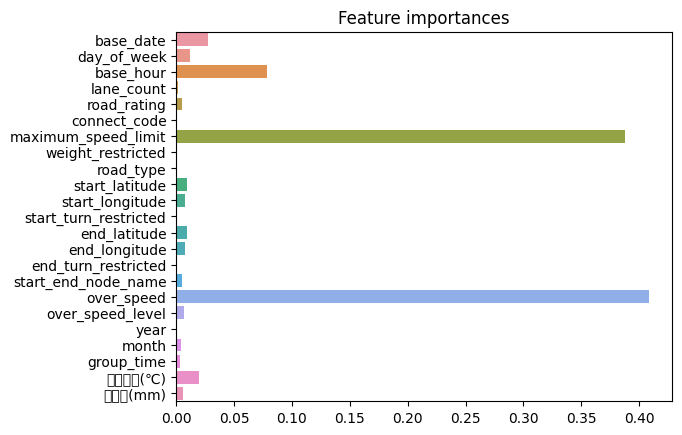

In [228]:
feature_names = X_train.columns
importances = tree_model.feature_importances_
sns.barplot(y=feature_names, x=importances, estimator=np.mean)
plt.title("Feature importances")
plt.show()

In [236]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
mae_scores = -scores  # 음수로 반환되기 때문에 다시 양수로 변환

print("Mean MAE:", mae_scores.mean())
print("Standard Deviation:", mae_scores.std())

Mean MAE: 4.163047128322551
Standard Deviation: 0.0688918045509618
